In [4]:
!git clone https://github.com/tanisha0804/Industry-Academia-alignment.git

Cloning into 'Industry-Academia-alignment'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 57 (delta 13), reused 39 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 2.25 MiB | 30.66 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [5]:
!pip install pyPDF2
import re
import json
from pathlib import Path
from PyPDF2 import PdfReader
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.5 MB/s eta 0:00:00


In [6]:
repo_root = Path(".")

handbook_paths = [
    repo_root / "/content/Industry-Academia-alignment/data/university/Handbook 2022-2026.pdf",
    repo_root / "/content/Industry-Academia-alignment/data/university/Handbook batch 2023-2027.pdf"
]


In [7]:
repo_root = Path(".")

with open(repo_root / "/content/Industry-Academia-alignment/outputs/processed_data/industry_skill_clusters.json") as f:
    industry_clusters = json.load(f)


In [8]:
'''Initial extraction grouped high-level academic descriptors rather than
technical course content. To ensure valid industry–academia comparison, university
skills were re-extracted from course titles and syllabus topics'''
def extract_pdf_text(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text + "\n"
    return text


university_text = ""
for path in handbook_paths:
    university_text += extract_pdf_text(path)

print("Total extracted text length:", len(university_text))

Total extracted text length: 295517


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text


university_clean_text = clean_text(university_text)

In [10]:
CORE_TECH_KEYWORDS = [
    "data structures", "algorithms", "operating systems",
    "computer networks", "dbms", "database systems",
    "software engineering", "object oriented programming",
    "java", "python", "c programming", "c++",
    "machine learning", "artificial intelligence",
    "deep learning", "data science",
    "compiler design", "theory of computation",
    "computer architecture", "microprocessors",
    "web technologies", "cloud computing",
    "cyber security", "information security",
    "distributed systems", "parallel computing",
    "mobile application development", "iot",
    "big data", "data mining", "blockchain",
    "devops", "linux", "unix"
]
#standard CS curriculum topics

In [11]:
university_skills = set()

for keyword in CORE_TECH_KEYWORDS:
    if keyword in university_clean_text:
        university_skills.add(keyword)

print("Extracted university skills:", len(university_skills))
print(sorted(university_skills))

Extracted university skills: 33
['algorithms', 'artificial intelligence', 'big data', 'blockchain', 'c programming', 'c++', 'cloud computing', 'compiler design', 'computer architecture', 'computer networks', 'cyber security', 'data mining', 'data science', 'data structures', 'database systems', 'dbms', 'deep learning', 'devops', 'distributed systems', 'information security', 'iot', 'java', 'linux', 'machine learning', 'microprocessors', 'object oriented programming', 'operating systems', 'parallel computing', 'python', 'software engineering', 'theory of computation', 'unix', 'web technologies']


In [12]:
output_dir = repo_root / "/content/Industry-Academia-alignment/outputs/processed_data"
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / "university_skill_universe_v2.json", "w") as f:
    json.dump(sorted(university_skills), f, indent=2)

print("Phase 3.1 completed")

Phase 3.1 completed


In [13]:
repo_root = Path(".")
processed_dir = repo_root / "/content/Industry-Academia-alignment/outputs/processed_data"

with open(processed_dir / "industry_skill_universe.json") as f:
    industry_skills_raw = set(json.load(f))

with open(processed_dir / "university_skill_universe_v2.json") as f:
    university_skills_raw = set(json.load(f))

print("Industry skills:", len(industry_skills_raw))
print("University skills:", len(university_skills_raw))

Industry skills: 86
University skills: 33


In [14]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

model = SentenceTransformer("all-MiniLM-L6-v2")

all_skills = sorted(industry_skills_raw | university_skills_raw)
embeddings = model.encode(all_skills)

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,  #key value that changes the clusters
    metric="cosine",
    linkage="average"
)

labels = clustering.fit_predict(embeddings)

skill_clusters = defaultdict(list)
for skill, label in zip(all_skills, labels):
    skill_clusters[label].append(skill)

def choose_canonical(cluster):
    return sorted(cluster, key=lambda x: (len(x.split()), len(x)))[0]

canonical_map = {
    skill: choose_canonical(cluster)
    for cluster in skill_clusters.values()
    for skill in cluster
}

print("Canonical skill count:", len(set(canonical_map.values())))


Canonical skill count: 46


In [15]:
industry_skills_canonical = {
    canonical_map[s] for s in industry_skills_raw
}

university_skills_canonical = {
    canonical_map[s] for s in university_skills_raw
}

print("Industry skills (canonical):", len(industry_skills_canonical))
print("University skills (canonical):", len(university_skills_canonical))

Industry skills (canonical): 41
University skills (canonical): 18


In [16]:
for cid, cluster in list(skill_clusters.items())[:10]:
    print(cluster)

['API Testing', 'API fundamentals']
['AVEVA E3D/PDMS']
['Adobe Photoshop']
['Algorithms', 'Basic Algorithms', 'algorithms', 'theory of computation']
['Big Data Processing', 'big data']
['C# .NET']
['C++', 'Core Programming', 'Core programming', 'Programming language', 'c programming', 'c++', 'compiler design']
['CAD modeling', 'Technical drawing']
['CI/CD Pipelines', 'CI/CD pipelines']
['CMS Management']


In [17]:
#normalizing the skills
def normalize_skill(skill):
    skill = skill.lower()
    skill = re.sub(r"[^a-z0-9\s\+\#\.]", "", skill)
    skill = re.sub(r"\s+", " ", skill).strip()

    # remove filler words
    noise = [
        "programming", "scripting", "development",
        "proficiency", "skills", "experience", "basics"
    ]
    for n in noise:
        skill = skill.replace(f" {n}", "")

    return skill.strip()


In [18]:
industry_skills = {normalize_skill(s) for s in industry_skills_canonical}
university_skills = {normalize_skill(s) for s in university_skills_canonical}

print("Normalized industry skills:", len(industry_skills))
print("Normalized university skills:", len(university_skills))

Normalized industry skills: 41
Normalized university skills: 18


In [19]:
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

nlp_model = SentenceTransformer("all-MiniLM-L6-v2")

In [20]:
#NLP semantic coverage to find out similar topics
def is_semantically_covered_nlp(industry_skill, university_skills, threshold=0.6):
    """
    Returns:
    - covered (bool)
    - best_matching_university_skill (str)
    - similarity_score (float)
    """
    skill_emb = nlp_model.encode([industry_skill])
    uni_list = list(university_skills)
    uni_embs = nlp_model.encode(uni_list)

    sims = cosine_similarity(skill_emb, uni_embs)[0]
    best_idx = np.argmax(sims)

    return sims[best_idx] >= threshold, uni_list[best_idx], sims[best_idx]

In [21]:
missing_in_university = set()
covered_skills = set()
coverage_explanations = {}

for skill in industry_skills:
    if skill in university_skills:
        covered_skills.add(skill)
        coverage_explanations[skill] = ("direct", skill, 1.0)
    else:
        covered, match, score = is_semantically_covered_nlp(skill, university_skills)
        if covered:
            covered_skills.add(skill)
            coverage_explanations[skill] = ("semantic", match, round(score, 3))
        else:
            missing_in_university.add(skill)

In [22]:
#SKILL GAP ANALYSIS
coverage_percent = round(
    (len(covered_skills) / len(industry_skills)) * 100, 2
)

print("Industry skills:", len(industry_skills))
print("Covered by university:", len(covered_skills))
print("Missing in syllabus:", len(missing_in_university))
print("Coverage %:", coverage_percent)

Industry skills: 41
Covered by university: 14
Missing in syllabus: 27
Coverage %: 34.15


In [23]:
for skill, info in list(coverage_explanations.items())[:10]:
    print(skill, "→", info)

data analysis → ('semantic', 'data science', np.float32(0.669))
data mining → ('direct', 'data mining', 1.0)
big data → ('direct', 'big data', 1.0)
python → ('direct', 'python', 1.0)
java → ('direct', 'java', 1.0)
mlops → ('direct', 'mlops', 1.0)
unix → ('direct', 'unix', 1.0)
sql → ('direct', 'sql', 1.0)
cloud computing → ('direct', 'cloud computing', 1.0)
c++ → ('direct', 'c++', 1.0)


In [24]:
def make_json_safe(obj):
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_safe(v) for v in obj]
    elif hasattr(obj, "item"):  # numpy scalar
        return obj.item()
    else:
        return obj


gap_output = {
    "industry_skill_count": int(len(industry_skills)),
    "university_skill_count": int(len(university_skills)),
    "coverage_percent": float(coverage_percent),
    "covered_skills": sorted(covered_skills),
    "missing_skills": sorted(missing_in_university),
    "coverage_explanations": make_json_safe(coverage_explanations)
}
with open(processed_dir / "skill_gap_analysis.json", "w") as f:
    json.dump(gap_output, f, indent=2)


As per the results we understand that although foundational concepts are taught, industry-critical tools and practices such as Docker, CI/CD, Git, testing frameworks, and visualization tools are either missing or only implicitly addressed, leading to a measurable skills gap of ~66%.

In [27]:
import json
from pathlib import Path

processed_dir = Path("/content/Industry-Academia-alignment/outputs/processed_data/")

with open(processed_dir / "skill_gap_analysis.json") as f:
    gap_data = json.load(f)

missing_skills = gap_data["missing_skills"]

print("Total missing skills:", len(missing_skills))

Total missing skills: 27


In [28]:
'''currently we are manually filling the yearwise topics
but on expanding it with multiple universities - we can have historical syllabus labelling
we would not require manual filling on later stages
this approach has been taken for current single university approach
'''
YEAR_TOPIC_ANCHORS = {
    1: [
        "programming basics", "c programming", "python basics",
        "discrete mathematics", "operating systems", "computer fundamentals"
    ],
    2: [
        "data structures", "algorithms", "database systems",
        "object oriented programming", "software engineering"
    ],
    3: [
        "machine learning", "data science", "cloud computing",
        "distributed systems", "web development"
    ],
    4: [
        "devops", "mlops", "system design",
        "big data", "advanced analytics", "capstone project"
    ]
}


In [29]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed anchors
year_embeddings = {
    year: model.encode(topics)
    for year, topics in YEAR_TOPIC_ANCHORS.items()
}

skill_year_mapping = {}

for skill in missing_skills:
    skill_emb = model.encode([skill])

    best_year = None
    best_score = -1

    for year, emb in year_embeddings.items():
        score = cosine_similarity(skill_emb, emb).max()
        if score > best_score:
            best_score = score
            best_year = year

    skill_year_mapping[skill] = best_year

print("Skill → Year mapping created.")

Skill → Year mapping created.


In [30]:
with open(processed_dir / "skill_year_mapping.json", "w") as f:
    json.dump(skill_year_mapping, f, indent=2)

print("Saved skill_year_mapping.json")

Saved skill_year_mapping.json


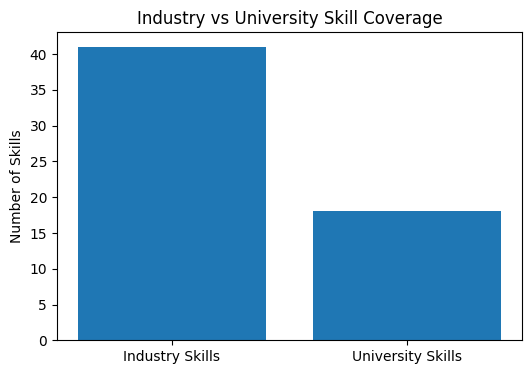

In [31]:
import matplotlib.pyplot as plt

labels = ["Industry Skills", "University Skills"]
values = [
    len(industry_skills_canonical),
    len(university_skills_canonical)
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Industry vs University Skill Coverage")
plt.ylabel("Number of Skills")
plt.show()

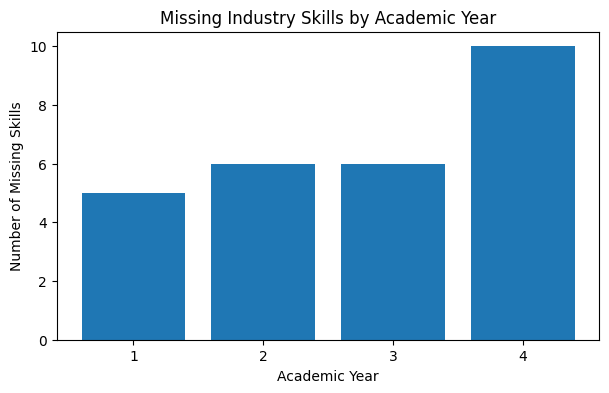

In [32]:
from collections import Counter

year_counts = Counter(skill_year_mapping.values())

years = sorted(year_counts.keys())
counts = [year_counts[y] for y in years]

plt.figure(figsize=(7,4))
plt.bar(years, counts)
plt.xticks(years)
plt.xlabel("Academic Year")
plt.ylabel("Number of Missing Skills")
plt.title("Missing Industry Skills by Academic Year")
plt.show()

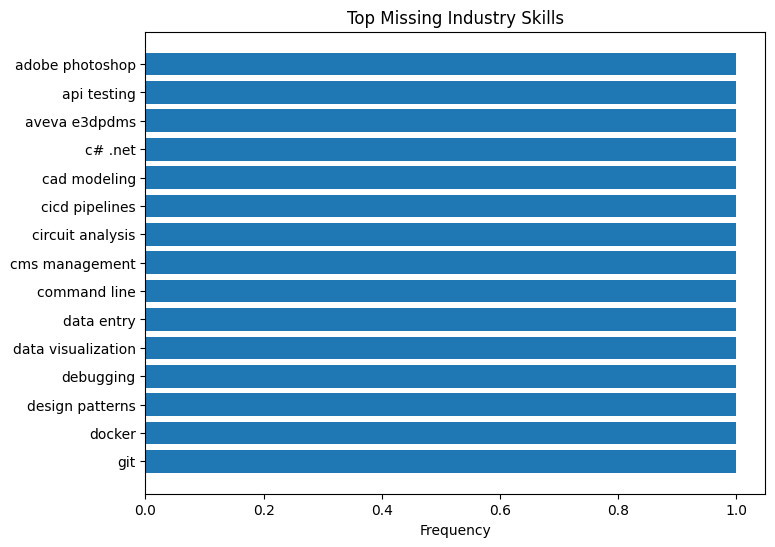

In [33]:
top_missing = Counter(skill_year_mapping.keys()).most_common(15)

skills = [s for s, _ in top_missing]
freqs = [f for _, f in top_missing]

plt.figure(figsize=(8,6))
plt.barh(skills[::-1], freqs[::-1])
plt.xlabel("Frequency")
plt.title("Top Missing Industry Skills")
plt.show()

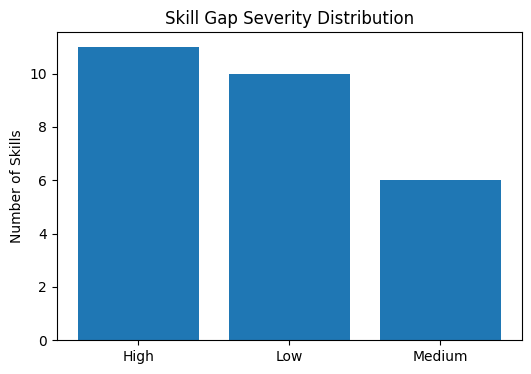

In [34]:
'''
Year 1–2 → High severity
Year 3 → Medium
Year 4 → Low
'''
severity_map = {
    1: "High",
    2: "High",
    3: "Medium",
    4: "Low"
}

severity_counts = Counter(
    severity_map[y] for y in skill_year_mapping.values()
)

plt.figure(figsize=(6,4))
plt.bar(severity_counts.keys(), severity_counts.values())
plt.title("Skill Gap Severity Distribution")
plt.ylabel("Number of Skills")
plt.show()

In [35]:
import pandas as pd

summary_df = pd.DataFrame({
    "Metric": [
        "Total Industry Skills",
        "Total University Skills",
        "Missing Skills",
        "Coverage (%)"
    ],
    "Value": [
        len(industry_skills_canonical),
        len(university_skills_canonical),
        len(missing_skills),
        round(
            100 * len(university_skills_canonical) / len(industry_skills_canonical),
            2
        )
    ]
})

summary_df

,Metric,Value
0,Total Industry Skills,41.0
1,Total University Skills,18.0
2,Missing Skills,27.0
3,Coverage (%),43.9
